# Data exploration of geoclim and GBS sequencing data from wild coffee tree samples

## About the data
### Source
Hamon P, Grover CE, Davis AP, Rakotomalala JJ, Raharimalala NE, Albert VA, Sreenath HL, Stoffelen P, Mitchell SE, Couturon E, Hamon S, de Kochko A, Crouzillat D, Rigoreau M, Sumirat U, Akaffou S, Guyot R. Genotyping-by-sequencing provides the first well-resolved phylogeny for coffee (Coffea) and insights into the evolution of caffeine content in its species: GBS coffee phylogeny and the evolution of caffeine content. Mol Phylogenet Evol. 2017 Apr;109:351-361. doi: 10.1016/j.ympev.2017.02.009. Epub 2017 Feb 16. PMID: 28212875.

### Metadata
Metadata table in [data directory](coffeaPhyloGeo/data/geoclim/geospatial/coff_madag_species_summary.xlsx)

**Genetic data :**
GBS/Rad-Seq from nuclear DNA. Data cleaning, ref-genome alignement + SNP concat #TODO

**geoclim data :**
GPS positions available in metadata table. To use to extract information on the [Madaclim](https://madaclim.cirad.fr/) database.

---

**All required imports and utils**

In [463]:
import pandas as pd
from pathlib import Path
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio import plot
from definitions import *
import geopandas as gpd
from shapely.geometry import Point
import calendar
import re
import seaborn as sns

## Climate data extraction

### Paths and file configs
See definitions.py for dir paths + config.yaml ref

In [464]:
# File names
print("\n".join([METADATA_RAW, GPS_ALL,GPS_GBS_ONLY, MADACLIM_CURRENT_TIF]))

coff_madag_species_summary.xlsx
species_locations_all_positions.csv
species_locations_gbs_only.csv
madaclim_current.tif


### GPS position extraction from metadata + cleaning
Generate 2 csv files for 2 subsets using Pandas :
- all specimens WITH GPS positions (df_gps_all)
- only specimens with BOTH GPS and SNP.fasta (df_gbs_only)

In [465]:
# Read from raw table
df = pd.read_excel(GEOSPATIAL_DIR / METADATA_RAW, decimal=",")
df = df.dropna(how="all")
df.head()

,Species,GBS sequence,Botanical series,Genome size (2C. pg),Latitude,Longitude,Species code,Population code
0,C.abbayesii,C_abbayesii_A601,Millotii,1.25,-24.7541,46.8624,ABA,A601
1,C.ambodirianenis,C_ambodirianensis_A572,Millotii,1.27,-18.4522,48.9433,AMB,A572
2,C.ambongensis,C_ambongensis,Baracoffea,1.16,-15.5745833,46.4198056,AMBON,BR071
3,C.ankaranensis,C_ankaranensis_A525,Multiflorae \n,1.17,-12.9491,49.5433,ANK1,A525
4,C.ankaranensis,-,Multiflorae \n,1.17,-12.8491,49.5433,ANK2,A808


**Note for later** Use madaclim to impute missing gps POS on samples : 
- RNF785
- APD3096
- A1013

In [466]:
# Read from raw table
df = pd.read_excel(GEOSPATIAL_DIR / METADATA_RAW, decimal=",")

# Remove blank rows
df = df.dropna(how="all")
df["GBS sequence"] = df["GBS sequence"].str.rstrip()    #* \n still present after stripping

# Remove \n in Botanical series
df = df.replace(r"\n","", regex=True)

# Converting to proper NaN and reordering
df = df.replace({"-": np.nan, "NO POSITION": np.nan})
df = df[["Species", "Species code", "Population code", "GBS sequence", "Botanical series", "Genome size (2C. pg)", "Latitude", "Longitude"]]
# Remove NO from AND2 species
df["Longitude"] = df["Longitude"].str.replace("NO ", "")
df["Longitude"] = df["Longitude"].str.replace(",", ".").astype(float)

df.head()


,Species,Species code,Population code,GBS sequence,Botanical series,Genome size (2C. pg),Latitude,Longitude
0,C.abbayesii,ABA,A601,C_abbayesii_A601,Millotii,1.25,-24.7541,46.862400
1,C.ambodirianenis,AMB,A572,C_ambodirianensis_A572,Millotii,1.27,-18.4522,48.943300
2,C.ambongensis,AMBON,BR071,C_ambongensis,Baracoffea,1.16,-15.5745833,46.419806
3,C.ankaranensis,ANK1,A525,C_ankaranensis_A525,Multiflorae,1.17,-12.9491,49.543300
4,C.ankaranensis,ANK2,A808,NaN,Multiflorae,1.17,-12.8491,49.543300


In [467]:
# Keep df for all species WITH GPS positions and reorder
df_gps_all = df
df_gps_all = df_gps_all.dropna(subset=["Latitude", "Longitude"])
print(f"Number of samples for all specimens WITH GPS : {len(df_gps_all)}")
df_gps_all = df_gps_all.reset_index().drop(columns=["index"])

Number of samples for all specimens WITH GPS : 51


In [468]:
# Clean for missing GBS sequences
df_gbs_only = df_gps_all.dropna()
print(f"Number of samples for specimens with BOTH GPS AND genetic data : {len(df_gbs_only)}")
df_gbs_only = df_gbs_only.reset_index().drop(columns=["index"])

Number of samples for specimens with BOTH GPS AND genetic data : 41


**Save as csv to data/geoclim/geospatial/**

In [469]:
# Save cleaned data to csv in geospatial dir
# df_gps_all.to_csv(GEOSPATIAL_DIR / GPS_ALL, index=False)  # All positions available
# df_gbs_only.to_csv(GEOSPATIAL_DIR / GPS_GBS_ONLY, index=False)    # Species with both gbs AND positions

### Raster file basic manipulations

In [470]:
# Open raster file
raster_mada = rasterio.open(CLIMATE_DIR / MADACLIM_CURRENT_TIF)
print(f"File opened ? {not(raster_mada.closed)}")


File opened ? True


In [471]:
# Check for dtypes
if len(set(raster_mada.dtypes)) > 1 :
    print(f"Raster file {MADACLIM_CURRENT_TIF} has more than one dtypes")
    print(set(raster_mada.dtypes))
else:
    print(f"Raster file {MADACLIM_CURRENT_TIF} has only {set(raster_mada.dtypes)}")    

# Get dict for all band dtypes combinations
bands_types = {i: dtype for i, dtype in zip(raster_mada.indexes, raster_mada.dtypes)}
# print(bands_types)

Raster file madaclim_current.tif has only {'int16'}


In [472]:
# Number of bands total
print(f"{MADACLIM_CURRENT_TIF} has {len(raster_mada.indexes)} bands")

madaclim_current.tif has 70 bands


In [473]:
# Get CRS + bounds
print(f"CRS of {MADACLIM_CURRENT_TIF} : {raster_mada.crs}")

CRS of madaclim_current.tif : EPSG:32738


In [474]:
raster_mada.bounds

BoundingBox(left=298000.0, bottom=7155000.0, right=1101000.0, top=8683000.0)

In [475]:
# band1
band1 = raster_mada.read(1)
band1[raster_mada.height // 2, raster_mada.width // 2]

120

In [476]:
#nodata value
raster_mada.nodata

-32768.0

#### Plotting individual bands and distributions

Example with band 37 = bio1_Mean Annual Temperature

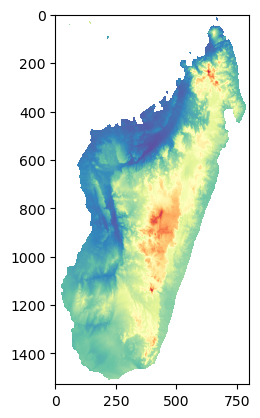

<AxesSubplot: >

In [477]:
# bio1_Annual Mean Temp associated with band37 (see example in section below)
rasterio.plot.show(raster_mada.read(37, masked=True), cmap="Spectral")

Underneat the hood, this is just a masked numpy array that is calling the imshow() method on an axes object.

In [478]:
raster_mada.read(1, masked=True).compressed()[:5]

array([209, 208, 205, 204, 204], dtype=int16)

We could than apply the compressed method to the raster.read(band#) array and plot a more customized version

Text(0.5, 1.0, 'Number of dry months per year\n')

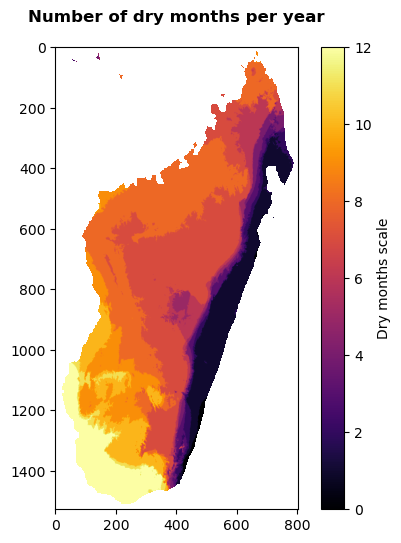

In [479]:
# For number of dry months
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(raster_mada.read(70, masked=True), cmap="inferno", norm="linear")
cbar = plt.colorbar(im)
cbar.ax.set_ylabel("Dry months scale")
plt.title("Number of dry months per year\n", weight="bold")

Again, same for distributions histograms

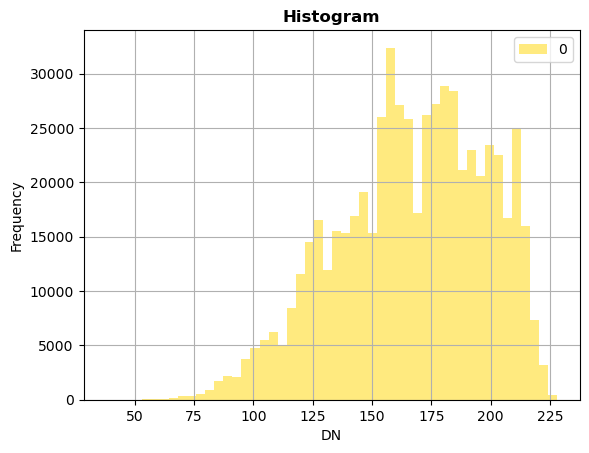

In [480]:
# With rasterio
fig, ax = plt.subplots()

rasterio.plot.show_hist(
    raster_mada.read(1, masked=True), bins=50, stacked=False, alpha=0.5,
    histtype='stepfilled', title="Histogram", label="0", ax=ax,
)

Text(0.5, 1.0, 'Distribution data for band37 (bio1)')

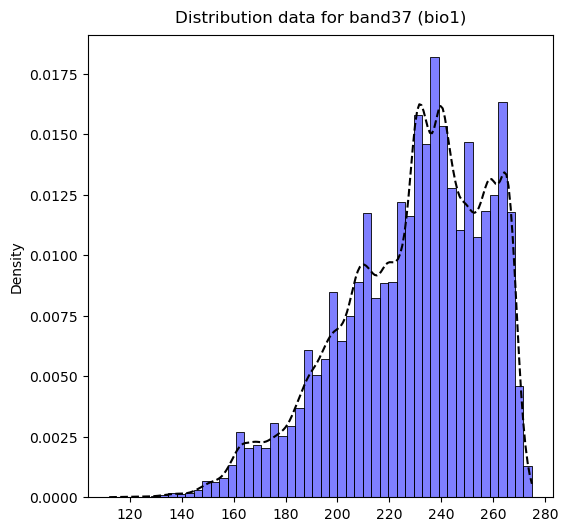

In [481]:
# With seaborn
fig, ax = plt.subplots(1, 1, figsize=(6,6))
sns.histplot(
    data=raster_mada.read(37, masked=True).compressed(),
    color="blue",
    bins=50,
    ax=ax,
    kde=True, stat="density",
    line_kws={"linestyle" : "--"}
)
ax.lines[0].set_color("black")
ax.set_title("Distribution data for band37 (bio1)", pad=10)

Combining both side by side

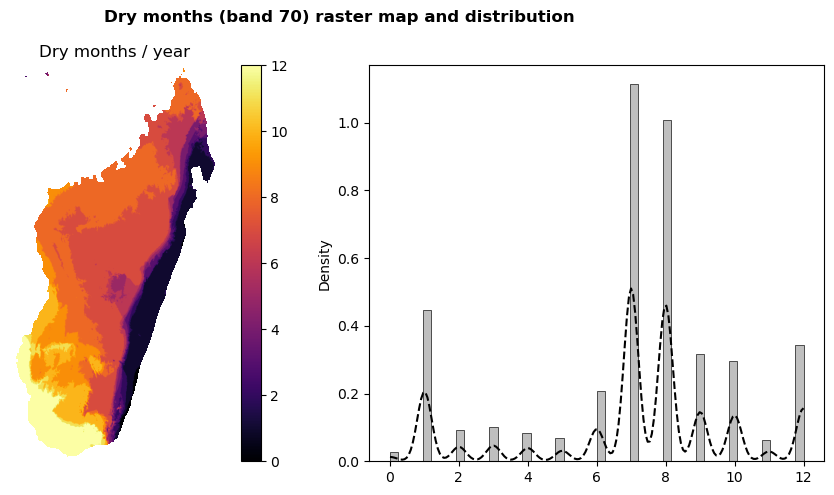

In [482]:
# Selecting the band
band_num = 70
band = raster_mada.read(band_num, masked=True)

# Plotting both map and distributions of raster values
fig, axes = plt.subplots(1, 2, figsize=(10,5))

# Raster map
im = axes[0].imshow(band, cmap="inferno", norm="linear")
cbar = plt.colorbar(im)
axes[0].set_title("Dry months / year")
axes[0].set_yticks([])
axes[0].set_xticks([])
axes[0].axis("off")

# Pixel vals distributions
sns.histplot(
    data=band.compressed(), color="grey", bins=50, ax=axes[1], 
    kde=True, stat="density",
    line_kws={"linestyle" : "--"}
)
axes[1].lines[0].set_color("black")

fig.suptitle("Dry months (band 70) raster map and distribution", weight="bold")
fig.tight_layout()

### Defining the climate variables to get from raster

Get info for bioclim vars

In [483]:
# bioclim vars
def label_bioclim_vars():
    bio1_bio19 = [f"{k}_{v['longname']}" for k,v in config["bioclim_defs"].items()]
    bio_layers = {}
    for i, bio in enumerate(bio1_bio19, start=37):
        bio_layers[f"layer{i}"] = bio
    return bio_layers
label_bioclim_vars ()


{'layer37': 'bio1_Annual Mean Temperature',
 'layer38': 'bio2_Mean Diurnal Range(Mean(period max-min)',
 'layer39': 'bio3_Isothermality 2/7',
 'layer40': 'bio4_Temperature Seasonality (C of V)',
 'layer41': 'bio5_Max Temperature of Warmest Period',
 'layer42': 'bio6_Min Temperature of Coldest Period',
 'layer43': 'bio7_Temperature Annual Range (5-6)',
 'layer44': 'bio8_Temperature Annual Range (5-6)',
 'layer45': 'bio9_Mean Temperature of Driest Quarter',
 'layer46': 'bio10_Mean Temperature of Warmest Quarter',
 'layer47': 'bio11_Mean Temperature of Coldest Quarter',
 'layer48': 'bio12_Annual Precipitation',
 'layer49': 'bio13_Precipitation of Wettest Period',
 'layer50': 'bio14_Precipitation of Driest Period',
 'layer51': 'bio15_Precipitation Seasonality(C of V)',
 'layer52': 'bio16_Precipitation of Wettest Quarter',
 'layer53': 'bio17_Precipitation of Driest Quarter',
 'layer54': 'bio18_Precipitation of Warmest Quarter',
 'layer55': 'bio19_Precipitation of Coldest Quarter'}

Get info for monthly vars

In [484]:
# Layers description for monthly vars
l1_12 = "Monthly minimum temperature (C x 10)"
l13_24 = "Monthly maximum temperature (C x 10)"
l25_36 = "Monthly total precipitation (mm.month-1)"
l56_67 = "Monthly potential evapotranspiration (mm.month-1)"

In [485]:
def label_monthly_vars(description, first_layer):
    layers = {}
    monthly_vars = [f"{description}_{month}" for month in calendar.month_name[1:]]
    for i, month in enumerate(monthly_vars, start=first_layer):
        layers[f"layer{i}"] = month
    return layers

Get info for annual vars

In [486]:
l68 = {"layer68" : "Annual potential evapotranspiration (mm)"}
l69 = {"layer69" : "Annual climatic water deficit (mm)"}
l70 = {"layer70" : "Number of dry months in the year"}

Generate all vars dictionary

In [487]:
# Layers 1 to 12
mada_layers = {}
temp_layers = label_monthly_vars(l1_12, 1)
mada_layers.update(temp_layers)

# Layers 13 to 24
temp_layers = label_monthly_vars(l13_24, 13)
mada_layers.update(temp_layers)

# Layers 25 to 36
temp_layers = label_monthly_vars(l25_36, 25)
mada_layers.update(temp_layers)

# Layers 37 to 55 (bioclim)
temp_layers = label_bioclim_vars()
mada_layers.update(temp_layers)

# Layers 56 to 67
temp_layers = label_monthly_vars(l56_67, 56)
mada_layers.update(temp_layers)

# Layers 68 to 70
mada_layers.update(l68)
mada_layers.update(l69)
mada_layers.update(l70)

mada_layers

{'layer1': 'Monthly minimum temperature (C x 10)_January',
 'layer2': 'Monthly minimum temperature (C x 10)_February',
 'layer3': 'Monthly minimum temperature (C x 10)_March',
 'layer4': 'Monthly minimum temperature (C x 10)_April',
 'layer5': 'Monthly minimum temperature (C x 10)_May',
 'layer6': 'Monthly minimum temperature (C x 10)_June',
 'layer7': 'Monthly minimum temperature (C x 10)_July',
 'layer8': 'Monthly minimum temperature (C x 10)_August',
 'layer9': 'Monthly minimum temperature (C x 10)_September',
 'layer10': 'Monthly minimum temperature (C x 10)_October',
 'layer11': 'Monthly minimum temperature (C x 10)_November',
 'layer12': 'Monthly minimum temperature (C x 10)_December',
 'layer13': 'Monthly maximum temperature (C x 10)_January',
 'layer14': 'Monthly maximum temperature (C x 10)_February',
 'layer15': 'Monthly maximum temperature (C x 10)_March',
 'layer16': 'Monthly maximum temperature (C x 10)_April',
 'layer17': 'Monthly maximum temperature (C x 10)_May',
 'laye

Example to find layer# of Mean Annual temperature

In [488]:
for k,v in mada_layers.items():
    if re.search("[Aa]nnual Mean", mada_layers[k]):
        print(k, v)

layer37 bio1_Annual Mean Temperature


### Creating Point objects for each specimen

Subset df

In [489]:
df_gbs = df_gbs_only[["Species code", "Genome size (2C. pg)", "Longitude", "Latitude"]]
print(f"df_gbs (both gps + genetic data) has {len(df_gbs)} specimens")
df_gbs.head()

df_gbs (both gps + genetic data) has 41 specimens


,Species code,Genome size (2C. pg),Longitude,Latitude
0,ABA,1.25,46.862400,-24.7541
1,AMB,1.27,48.943300,-18.4522
2,AMBON,1.16,46.419806,-15.5745833
3,ANK1,1.17,49.543300,-12.9491
4,ARE,1.11,48.200000,-18.9333


Create shapely.Point objects from GPS coordinates

In [490]:
# Beware of lon/lat order in instance creation
points = [Point(float(row["Longitude"]), float(row["Latitude"])) for index, row in df_gbs.iterrows()]
points[0:10]

[<POINT (46.862 -24.754)>,
 <POINT (48.943 -18.452)>,
 <POINT (46.42 -15.575)>,
 <POINT (49.543 -12.949)>,
 <POINT (48.2 -18.933)>,
 <POINT (49.167 -12.733)>,
 <POINT (46.633 -25.017)>,
 <POINT (46.812 -16.315)>,
 <POINT (46.827 -16.296)>,
 <POINT (49.88 -13.35)>]

Create GeoPandas dataframe

In [491]:
# Original coordinates under GPS format aka epsg:4326
gdf_gbs = "Reset"
gdf_gbs = gpd.GeoDataFrame(df_gbs, geometry=points, crs=4326)
gdf_gbs.head()

,Species code,Genome size (2C. pg),Longitude,Latitude,geometry
0,ABA,1.25,46.862400,-24.7541,POINT (46.86240 -24.75410)
1,AMB,1.27,48.943300,-18.4522,POINT (48.94330 -18.45220)
2,AMBON,1.16,46.419806,-15.5745833,POINT (46.41981 -15.57458)
3,ANK1,1.17,49.543300,-12.9491,POINT (49.54330 -12.94910)
4,ARE,1.11,48.200000,-18.9333,POINT (48.20000 -18.93330)


Check CRS + transform to Madaclim_current.tif raster CRS

In [492]:
gdf_gbs.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [493]:
gdf_gbs = gdf_gbs.to_crs(32738)
gdf_gbs.head()


,Species code,Genome size (2C. pg),Longitude,Latitude,geometry
0,ABA,1.25,46.862400,-24.7541,POINT (688328.240 7260998.023)
1,AMB,1.27,48.943300,-18.4522,POINT (916635.952 7955240.629)
2,AMBON,1.16,46.419806,-15.5745833,POINT (652237.905 8277614.406)
3,ANK1,1.17,49.543300,-12.9491,POINT (993250.150 8564104.062)
4,ARE,1.11,48.200000,-18.9333,POINT (837072.915 7903496.321)


In [494]:
# to get the x/lon attribute of Point objects
gdf_gbs["geometry"].x.head()  #lon


0    688328.240325
1    916635.952187
2    652237.905456
3    993250.150336
4    837072.915024
dtype: float64

In [495]:
gdf_gbs.crs

<Derived Projected CRS: EPSG:32738>
Name: WGS 84 / UTM zone 38S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 42°E and 48°E, southern hemisphere between 80°S and equator, onshore and offshore. Madagascar.
- bounds: (42.0, -80.0, 48.0, 0.0)
Coordinate Operation:
- name: UTM zone 38S
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

View points on raster map

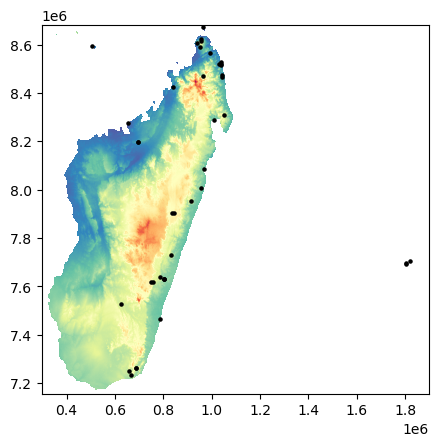

In [496]:
# Plotting with matplotlib.pyplot, rasterio.show and GeoPandas.plot modules
with rasterio.open(CLIMATE_DIR / MADACLIM_CURRENT_TIF) as raster_mada:

    fig, ax = plt.subplots()
    ax = rasterio.plot.show(raster_mada, ax=ax, cmap="Spectral")
    gdf_gbs.plot(ax=ax, color="black", markersize=5)


OK nice it works, we can improve visualization later. Still we see some outlier points that won't have any data (outgroups + others)

### Using GeoPandas with Rasterio to sample point data

In [497]:
# Open raster file
raster_mada = rasterio.open(CLIMATE_DIR / MADACLIM_CURRENT_TIF)
print(f"File opened ? {not(raster_mada.closed)}")

File opened ? True


In [498]:
gdf_gbs.head()

,Species code,Genome size (2C. pg),Longitude,Latitude,geometry
0,ABA,1.25,46.862400,-24.7541,POINT (688328.240 7260998.023)
1,AMB,1.27,48.943300,-18.4522,POINT (916635.952 7955240.629)
2,AMBON,1.16,46.419806,-15.5745833,POINT (652237.905 8277614.406)
3,ANK1,1.17,49.543300,-12.9491,POINT (993250.150 8564104.062)
4,ARE,1.11,48.200000,-18.9333,POINT (837072.915 7903496.321)


Extract for all coords + create cols on geodf

In [499]:
# Create a list of coordinates under EPSG:32738
coord_list = [(x,y) for x,y in zip(gdf_gbs["geometry"].x, gdf_gbs["geometry"].y)]
coord_list[0:5]
# print(len(coord_list))

[(688328.2403248843, 7260998.022932809),
 (916635.9521871379, 7955240.6291522365),
 (652237.9054559749, 8277614.406156755),
 (993250.1503363773, 8564104.062130136),
 (837072.9150244407, 7903496.320897499)]

In [500]:
# Slice first specimen for all raster layers
all_vals = [x for x in raster_mada.sample(coord_list)]
print(f"num specimens extracted : {len(all_vals)}")
all_vals[0]

num specimens extracted : 41


array([ 155,  195,  188,  171,  136,  122,  120,  124,  138,  173,  188,
        196,  276,  295,  288,  281,  266,  243,  235,  240,  259,  286,
        293,  297,   57,  181,  169,   73,   64,   73,   58,   57,   44,
        105,  175,  204,  215,  112,   63, 2597,  297,  120,  177,  238,
        186,  238,  180, 1260,  204,   44,   56,  484,  159,  484,  188,
         92,  125,  113,   94,   67,   50,   44,   47,   60,   92,  110,
        123, 1022,   77,    4], dtype=int16)

In [501]:
# Note to remove in df 2 outgroups since they have no data in the Madaclim db
print(f"Value of 'no data' in raster file : {raster_mada.nodata}")
all_vals[-3:]

Value of 'no data' in raster file : -32768.0


[array([ 173,  211,  206,  193,  163,  146,  142,  145,  155,  194,  203,
         213,  269,  295,  289,  281,  266,  250,  236,  240,  251,  285,
         294,  296,   71,  381,  394,  153,  100,  110,  110,  111,   81,
         171,  226,  379,  224,   92,   59, 2478,  296,  142,  154,  245,
         194,  247,  193, 2287,  394,   71,   64,  928,  302,  776,  331,
          93,  132,  121,  103,   75,   58,   49,   52,   62,  101,  117,
         131, 1099,   22,    1], dtype=int16),
 array([-32768, -32768, -32768, -32768, -32768, -32768, -32768, -32768,
        -32768, -32768, -32768, -32768, -32768, -32768, -32768, -32768,
        -32768, -32768, -32768, -32768, -32768, -32768, -32768, -32768,
        -32768, -32768, -32768, -32768, -32768, -32768, -32768, -32768,
        -32768, -32768, -32768, -32768, -32768, -32768, -32768, -32768,
        -32768, -32768, -32768, -32768, -32768, -32768, -32768, -32768,
        -32768, -32768, -32768, -32768, -32768, -32768, -32768, -32768,
     

We have all the data in a list of 41 (each specimens) arrays each containing 70 elements (each climvars)

We need to get this information ordered unto the GeoPandas df

In [502]:
# Add all_vals arrays in single col in df
gdf_gbs["all_layers"] = all_vals
gdf_gbs

,Species code,Genome size (2C. pg),Longitude,Latitude,geometry,all_layers
0,ABA,1.25,46.862400,-24.7541,POINT (688328.240 7260998.023),"[155, 195, 188, 171, 136, 122, 120, 124, 138, ..."
1,AMB,1.27,48.943300,-18.4522,POINT (916635.952 7955240.629),"[157, 203, 199, 185, 164, 149, 142, 139, 144, ..."
2,AMBON,1.16,46.419806,-15.5745833,POINT (652237.905 8277614.406),"[222, 236, 238, 235, 217, 199, 191, 193, 205, ..."
3,ANK1,1.17,49.543300,-12.9491,POINT (993250.150 8564104.062),"[206, 228, 227, 224, 211, 192, 186, 188, 194, ..."
4,ARE,1.11,48.200000,-18.9333,POINT (837072.915 7903496.321),"[130, 176, 166, 153, 126, 107, 109, 107, 114, ..."
5,AUGA,1.18,49.166660,-12.7333,POINT (952678.662 8588724.644),"[170, 195, 196, 190, 176, 157, 153, 155, 160, ..."
6,BERT,1.22,46.633300,-25.01666,POINT (664808.037 7232213.963),"[167, 214, 206, 185, 152, 135, 129, 132, 146, ..."
7,BISS,1.19,46.812299,-16.315048,POINT (693621.346 8195354.827),"[204, 223, 222, 215, 194, 172, 167, 173, 185, ..."
8,BOIN,1.15,46.826763,-16.295741,POINT (695186.217 8197477.648),"[201, 221, 220, 213, 192, 170, 166, 171, 184, ..."
9,BOI,1.00,49.880000,-13.35,POINT (1029017.945 8518947.447),"[207, 234, 229, 225, 211, 192, 191, 191, 197, ..."


In [503]:
# Adding each layer has a column (layer num + units) for each specimen
for i, (k, v) in enumerate(mada_layers.items()):
    for j, specimen in enumerate(all_vals):
        gdf_gbs.loc[j, f"{k} : {v}"] = specimen[i]
        

In [504]:
# Compare with all layers : OK
gdf_gbs.head()

,Species code,Genome size (2C. pg),Longitude,Latitude,geometry,all_layers,layer1 : Monthly minimum temperature (C x 10)_January,layer2 : Monthly minimum temperature (C x 10)_February,layer3 : Monthly minimum temperature (C x 10)_March,layer4 : Monthly minimum temperature (C x 10)_April,...,layer61 : Monthly potential evapotranspiration (mm.month-1)_June,layer62 : Monthly potential evapotranspiration (mm.month-1)_July,layer63 : Monthly potential evapotranspiration (mm.month-1)_August,layer64 : Monthly potential evapotranspiration (mm.month-1)_September,layer65 : Monthly potential evapotranspiration (mm.month-1)_October,layer66 : Monthly potential evapotranspiration (mm.month-1)_November,layer67 : Monthly potential evapotranspiration (mm.month-1)_December,layer68 : Annual potential evapotranspiration (mm),layer69 : Annual climatic water deficit (mm),layer70 : Number of dry months in the year
0,ABA,1.25,46.862400,-24.7541,POINT (688328.240 7260998.023),"[155, 195, 188, 171, 136, 122, 120, 124, 138, ...",155.0,195.0,188.0,171.0,...,50.0,44.0,47.0,60.0,92.0,110.0,123.0,1022.0,77.0,4.0
1,AMB,1.27,48.943300,-18.4522,POINT (916635.952 7955240.629),"[157, 203, 199, 185, 164, 149, 142, 139, 144, ...",157.0,203.0,199.0,185.0,...,61.0,47.0,48.0,56.0,92.0,109.0,121.0,1041.0,16.0,1.0
2,AMBON,1.16,46.419806,-15.5745833,POINT (652237.905 8277614.406),"[222, 236, 238, 235, 217, 199, 191, 193, 205, ...",222.0,236.0,238.0,235.0,...,107.0,93.0,102.0,120.0,164.0,164.0,156.0,1709.0,849.0,8.0
3,ANK1,1.17,49.543300,-12.9491,POINT (993250.150 8564104.062),"[206, 228, 227, 224, 211, 192, 186, 188, 194, ...",206.0,228.0,227.0,224.0,...,99.0,83.0,85.0,96.0,137.0,147.0,146.0,1482.0,501.0,8.0
4,ARE,1.11,48.200000,-18.9333,POINT (837072.915 7903496.321),"[130, 176, 166, 153, 126, 107, 109, 107, 114, ...",130.0,176.0,166.0,153.0,...,48.0,40.0,41.0,50.0,84.0,95.0,102.0,891.0,61.0,4.0


Removing the 2 last rows (outgroups) since they only have nodata values (positions out of Madaclim db)

In [505]:
print(f"Value of 'no data' in raster file : {raster_mada.nodata}")
gdf_gbs.tail(3) # See outgroups


Value of 'no data' in raster file : -32768.0


,Species code,Genome size (2C. pg),Longitude,Latitude,geometry,all_layers,layer1 : Monthly minimum temperature (C x 10)_January,layer2 : Monthly minimum temperature (C x 10)_February,layer3 : Monthly minimum temperature (C x 10)_March,layer4 : Monthly minimum temperature (C x 10)_April,...,layer61 : Monthly potential evapotranspiration (mm.month-1)_June,layer62 : Monthly potential evapotranspiration (mm.month-1)_July,layer63 : Monthly potential evapotranspiration (mm.month-1)_August,layer64 : Monthly potential evapotranspiration (mm.month-1)_September,layer65 : Monthly potential evapotranspiration (mm.month-1)_October,layer66 : Monthly potential evapotranspiration (mm.month-1)_November,layer67 : Monthly potential evapotranspiration (mm.month-1)_December,layer68 : Annual potential evapotranspiration (mm),layer69 : Annual climatic water deficit (mm),layer70 : Number of dry months in the year
38,AND2,1.2,47.942000,-21.40083,POINT (805033.840 7630631.025),"[173, 211, 206, 193, 163, 146, 142, 145, 155, ...",173.0,211.0,206.0,193.0,...,58.0,49.0,52.0,62.0,101.0,117.0,131.0,1099.0,22.0,1.0
39,MAU,0.96,57.433333,-20.416667,POINT (1804938.104 7692467.997),"[-32768, -32768, -32768, -32768, -32768, -3276...",-32768.0,-32768.0,-32768.0,-32768.0,...,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0
40,MYR,1.07,57.583333,-20.308333,POINT (1821822.952 7703446.045),"[-32768, -32768, -32768, -32768, -32768, -3276...",-32768.0,-32768.0,-32768.0,-32768.0,...,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0


Counting how many *nodata* points there are in the df

In [506]:
# Get number of cols that are not raster layers
l1_index = len(gdf_gbs.columns) - len(mada_layers)
print(f"Index num of Layer1 in df = {l1_index}")

Index num of Layer1 in df = 6


In [507]:
# Total number of elements
total_nodata = gdf_gbs.iloc[:, l1_index:][gdf_gbs.iloc[:, l1_index:] == raster_mada.nodata].dropna().count().sum()
print(f"There are {total_nodata} specimens datapoints of value {raster_mada.nodata}")
print(f"So probably {int(280/len(mada_layers))} (280nodata / #layers) specimens to remove")

There are 280 specimens datapoints of value -32768.0
So probably 4 (280nodata / #layers) specimens to remove


In [508]:
# Get list of indexes with nodata values (from raster convention)
nodata_indexes = gdf_gbs.iloc[:, l1_index:][gdf_gbs.iloc[:, l1_index:] == raster_mada.nodata].dropna().index.to_list()

# Drop them they are all outliers in the sense that all 70 layers are nodata
gdf_gbs.iloc[:, l1_index:][gdf_gbs.iloc[:, l1_index:] == raster_mada.nodata].dropna()

,layer1 : Monthly minimum temperature (C x 10)_January,layer2 : Monthly minimum temperature (C x 10)_February,layer3 : Monthly minimum temperature (C x 10)_March,layer4 : Monthly minimum temperature (C x 10)_April,layer5 : Monthly minimum temperature (C x 10)_May,layer6 : Monthly minimum temperature (C x 10)_June,layer7 : Monthly minimum temperature (C x 10)_July,layer8 : Monthly minimum temperature (C x 10)_August,layer9 : Monthly minimum temperature (C x 10)_September,layer10 : Monthly minimum temperature (C x 10)_October,...,layer61 : Monthly potential evapotranspiration (mm.month-1)_June,layer62 : Monthly potential evapotranspiration (mm.month-1)_July,layer63 : Monthly potential evapotranspiration (mm.month-1)_August,layer64 : Monthly potential evapotranspiration (mm.month-1)_September,layer65 : Monthly potential evapotranspiration (mm.month-1)_October,layer66 : Monthly potential evapotranspiration (mm.month-1)_November,layer67 : Monthly potential evapotranspiration (mm.month-1)_December,layer68 : Annual potential evapotranspiration (mm),layer69 : Annual climatic water deficit (mm),layer70 : Number of dry months in the year
22,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,...,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0
29,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,...,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0
39,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,...,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0
40,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,...,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0,-32768.0


In [509]:
gdf_gbs = gdf_gbs.drop(nodata_indexes)

In [510]:
# Sanity check
if not [ele for ele in (gdf_gbs.iloc[:, l1_index:] == raster_mada.nodata).any() if ele is True]:
    print("OK, no more 'nodata'")
len(gdf_gbs)

OK, no more 'nodata'


37

### Environmental data extraction

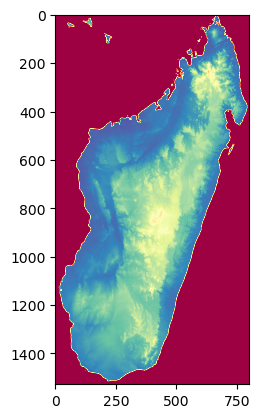

In [511]:
test = raster_mada.read(2)
test[test == -32768] = 0
plt.imshow(test, cmap="Spectral")


**DATA TRANSFORMATION INFORMATION:**

[Madaclim methods for climate db](https://madaclim.cirad.fr/methods-climate/)

## Climate data exploration

### Distributions per layer set

**Layers description reminder**

- layers1_12 ---> Monthly minimum temperature (C x 10)
- l13_24 ---> Monthly maximum temperature (C x 10)
- l25_36 ---> Monthly total precipitation (mm.month-1)
- l37_55 ---> bioclim
- l56_67 ---> Monthly potential evapotranspiration (mm.month-1)
- l68 ---> Annual potential evapotranspiration (mm)
- l69 ---> Annual climatic water deficit (mm)
- l70 ---> Number of dry months in the year

In [512]:
# Hardcoded
mada_layers_list = [d for d in mada_layers.items()]
layers1_12 = mada_layers_list[0:12]
layers13_24 = mada_layers_list[12:24]
layers25_36 = mada_layers_list[24:36]
layers37_55 = mada_layers_list[36:55]
layers56_67 = mada_layers_list[55:67]
layer68 = [mada_layers_list[67]]
layer69 = [mada_layers_list[68]]
layer70 = [mada_layers_list[69]]


In [513]:
# Same format as df
def get_layers(layers : dict, start : int, end=None):
    if end is None:
        end = start
    if start <1 :
        raise ValueError("Non-zero indexing for layers")
    elif end > len(layers):
        raise ValueError("Select a maximum that is within the range of layers")
    elif start > end:
        raise ValueError("Start layer must come before end layer")
    else :         
        selected_layers = []
        for i, (k, v) in enumerate(layers.items(), start=1):
            if i >= start and i <= end:
                selected_layers.append(f"{k} : {v}")
        return selected_layers

In [514]:
# Example for layers 68 to 70
print(get_layers(mada_layers, 68, 70))
print(f"\nThere are {len(mada_layers)} layers")

['layer68 : Annual potential evapotranspiration (mm)', 'layer69 : Annual climatic water deficit (mm)', 'layer70 : Number of dry months in the year']

There are 70 layers


In [515]:
# Specimens + positions cols
gdf_gbs.columns.to_list()[0:4]

['Species code', 'Genome size (2C. pg)', 'Longitude', 'Latitude']

In [516]:
# Subset df for layers 1 to 12
monthly_min = gdf_gbs.columns.to_list()[: l1_index] + get_layers(mada_layers, 1, 12)

gdf_gbs[monthly_min].head()

,Species code,Genome size (2C. pg),Longitude,Latitude,geometry,all_layers,layer1 : Monthly minimum temperature (C x 10)_January,layer2 : Monthly minimum temperature (C x 10)_February,layer3 : Monthly minimum temperature (C x 10)_March,layer4 : Monthly minimum temperature (C x 10)_April,layer5 : Monthly minimum temperature (C x 10)_May,layer6 : Monthly minimum temperature (C x 10)_June,layer7 : Monthly minimum temperature (C x 10)_July,layer8 : Monthly minimum temperature (C x 10)_August,layer9 : Monthly minimum temperature (C x 10)_September,layer10 : Monthly minimum temperature (C x 10)_October,layer11 : Monthly minimum temperature (C x 10)_November,layer12 : Monthly minimum temperature (C x 10)_December
0,ABA,1.25,46.862400,-24.7541,POINT (688328.240 7260998.023),"[155, 195, 188, 171, 136, 122, 120, 124, 138, ...",155.0,195.0,188.0,171.0,136.0,122.0,120.0,124.0,138.0,173.0,188.0,196.0
1,AMB,1.27,48.943300,-18.4522,POINT (916635.952 7955240.629),"[157, 203, 199, 185, 164, 149, 142, 139, 144, ...",157.0,203.0,199.0,185.0,164.0,149.0,142.0,139.0,144.0,179.0,194.0,203.0
2,AMBON,1.16,46.419806,-15.5745833,POINT (652237.905 8277614.406),"[222, 236, 238, 235, 217, 199, 191, 193, 205, ...",222.0,236.0,238.0,235.0,217.0,199.0,191.0,193.0,205.0,237.0,238.0,238.0
3,ANK1,1.17,49.543300,-12.9491,POINT (993250.150 8564104.062),"[206, 228, 227, 224, 211, 192, 186, 188, 194, ...",206.0,228.0,227.0,224.0,211.0,192.0,186.0,188.0,194.0,221.0,226.0,228.0
4,ARE,1.11,48.200000,-18.9333,POINT (837072.915 7903496.321),"[130, 176, 166, 153, 126, 107, 109, 107, 114, ...",130.0,176.0,166.0,153.0,126.0,107.0,109.0,107.0,114.0,152.0,164.0,175.0


<AxesSubplot: ylabel='Frequency'>

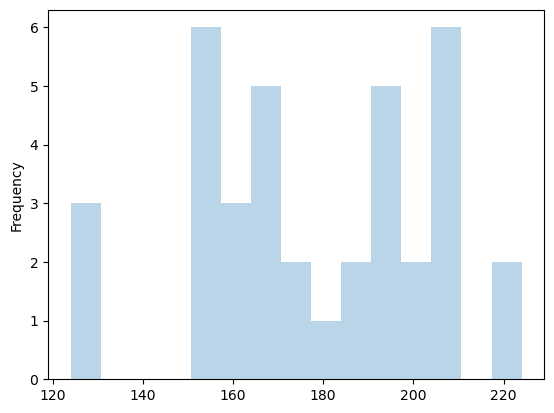

In [517]:
gdf_gbs[get_layers(mada_layers, 1, 1)].plot.hist(bins=15, legend=False, alpha=0.3)